# Signal denoising

Author: Julian Lißner<br>
For questions and feedback write a mail to: [lissner@mib.uni-stuttgart.de](mailto:lissner@mib.uni-stuttgart.de)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from numpy.fft import fft, ifft
from numpy import pi, sin, cos, tan
from scipy.signal import savgol_filter

sys.path.append( 'submodules' )
import general_functions as funcs


## Moving average


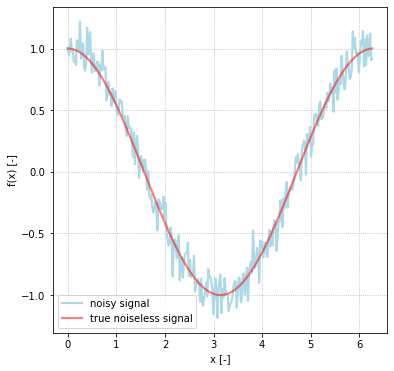

In [2]:
n_steps = 300
noise_magnitude = 0.1
x = np.arange( 0, 1, 1/n_steps) *2*pi
y = cos( x) 
noise = np.random.normal( 0, noise_magnitude, size=x.shape)
signal = noise + y

fig, ax = plt.subplots( figsize=(6,6))
ax.plot( x, signal, color='lightblue', lw=2.2, label='noisy signal')
ax.plot( x, y, color='red', alpha=0.5, lw=2.2, label='true noiseless signal')

def add_style( ax):
    ax.legend()
    ax.grid( ls=':')
    ax.set_xlabel( 'x [-]' )
    ax.set_ylabel( 'f(x) [-]' )
add_style(ax)

- moving average smoothes by considering direct neighbours
- average over adjacent $2m$ neighbours (left and right) is taken<br>
$\quad \blacktriangleright$ `window_length = 2m+1`
- the smoothed signal is defined as
$$  \hat s_i = \frac1{2m+1} \sum\limits_{j=-m}^m s_{(i+j)} $$
with $\hat s$: smoothed signal $\quad s$: noisy signal, for all $m<i<n-m$ 
- the signal is not defined at the borders $\blacktriangleright$ padding required
- recall definition of discrete convolution:
$$ (s \ast k)_i = \sum\limits_{j=-m}^m s_{i-j} \, k_j $$ <br>
- definition of the correlation ($$ f(x)\star g(x) = f(x) \ast g(-x)$$):
$$ (s \star k)_i = \sum\limits_{j=-m}^m s_{i+j} \, k_j $$ <br>
$\quad \blacktriangleright$ if $k_j=\frac1{2m+1}$ for all $j \blacktriangleright$ moving average
- the correlation is implemented similary to a convolution in Fourier space by taking the complex conjugate of the kernel/filter
- for symmetric kernels/filters the convolution and correlation coincide
- Note that below when writing convolution it refers to the correlation

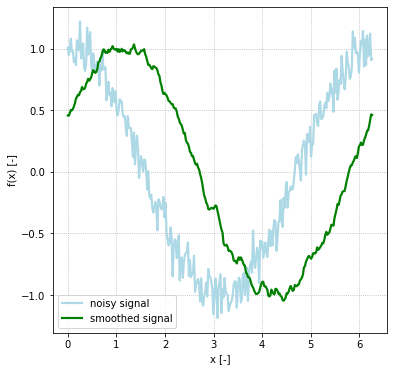

In [3]:
m = 3
window_length= 2*m +1
kernel = np.zeros( signal.shape)
kernel[ 50:50+window_length ] = 1/ window_length

smoothed_signal = ifft( fft( signal) *fft( kernel) ).real

fig, ax = plt.subplots( figsize=(6,6) )
ax.plot( x, signal, color='lightblue', lw=2.2, label='noisy signal')
ax.plot( x, smoothed_signal, color='green', lw=2.2, label='smoothed signal')
add_style( ax)

- FFT induces periodicity $\blacktriangleright$ perfect approximation of the periodicly defined cosine
- non-centered kernel introduces translation in convolution $\blacktriangleright$ solution is part of your implementation

### Denoising via matrix vector product
- instead of a summation with a kernel, a matrix vector multiplication can be conducted (c.f. twiddle factors in DFT)
- matrix has diagonal band structure filled repeatedly filled with values of the kernel
- moving average $\blacktriangleright$ diagonal band of 1 weighted with `window_length`
- matrix has many 0, usually better as sparse matrix

[[1 1 1 0 0 0 0 0 0]
 [1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0]
 [0 1 1 1 1 1 0 0 0]
 [0 0 1 1 1 1 1 0 0]
 [0 0 0 1 1 1 1 1 0]
 [0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 1 1 1]]


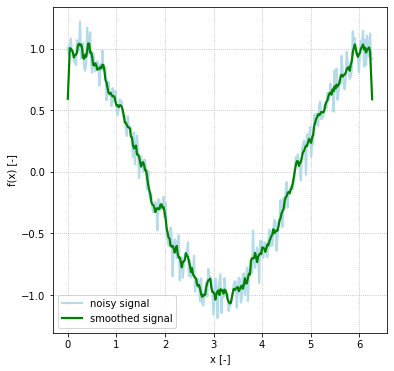

In [5]:
m = 2
window_length = 2*m +1
smoothing_matrix = funcs.band_diagonal( n_steps, width=m )
weight = 1/window_length
print( smoothing_matrix[:9, :9].astype(int) ) 
smoothing_matrix *= weight
smoothed_signal = smoothing_matrix @ signal 

fig, ax = plt.subplots( figsize=(6,6) )
ax.plot( x, signal, color='lightblue', alpha=0.9, lw=2.2, label='noisy signal')
ax.plot( x, smoothed_signal, color='green', lw=2.2, label='smoothed signal')
add_style( ax)

- no padding $\blacktriangleright$ boundary effect
- window length governs quality of denoising
- too small window length: not enough noise dampened
- too big window length: too much information smeared out

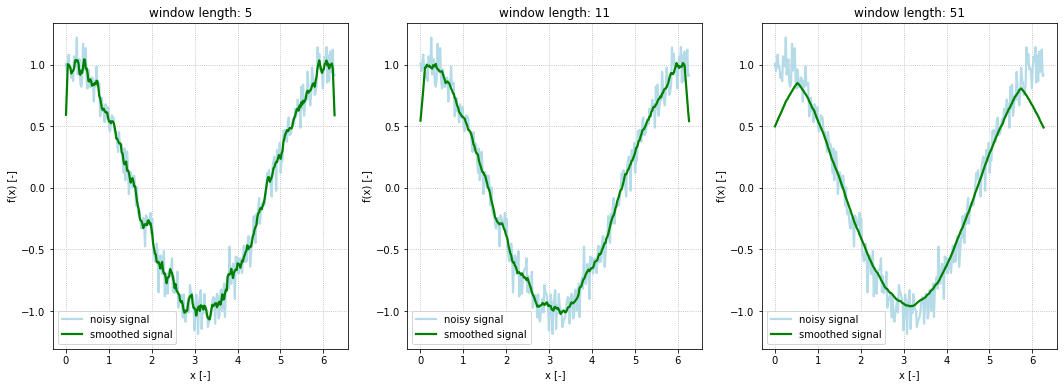

In [6]:
def moving_average( signal, window_length):
    """ Convenience function of the moving average implemented with matrix multiplication """
    smoothing_matrix =  funcs.band_diagonal( len(signal), window_length//2, value=1/window_length )
    return smoothing_matrix @ signal 

fig, axes = plt.subplots( 1,3, figsize=(18,6) )
i = 0
for window_length in [5, 11, 51]:
    smoothed_signal = moving_average( signal, window_length)
    axes[i].plot( x, signal, color='lightblue', alpha=0.9, lw=2.2, label='noisy signal')
    axes[i].plot( x, smoothed_signal, color='green', lw=2.2, label='smoothed signal')
    add_style( axes[i])
    axes[i].set_title( 'window length: {}'.format( window_length) )
    i += 1 

-----------------
-----------------
## Savitzky-Golay filter

- like moving average, can be implemented via a sum/indexing, convolution, or matrix multiplication
- instead of linear smoothing, piecewise polynomial smoothing
- `polynomial_order = 1` $\blacktriangleright$ moving average

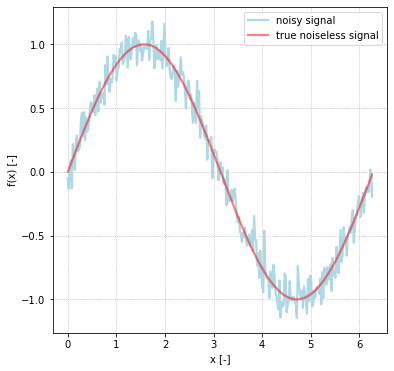

In [7]:
n_steps = 300
noise_magnitude = 0.1
x = np.arange( 0, 1, 1/n_steps) *2*pi
y = sin( x) 
noise = np.random.normal( 0, noise_magnitude, size=x.shape)
signal = noise + y
fig, ax = plt.subplots( figsize=(6,6))
ax.plot( x, signal, color='lightblue', lw=2.2, label='noisy signal')
ax.plot( x, y, color='red', alpha=0.5, lw=2.2, label='true noiseless signal')

add_style( ax)

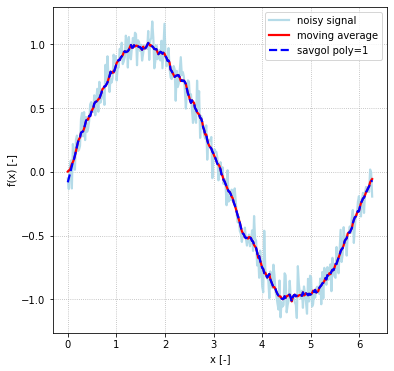

In [8]:
#help(savgol_filter) #always look at the documentation when using a new function
window_length = 11
averaged = moving_average( signal, window_length)
savgoled = savgol_filter( signal, window_length, polyorder=1 )

fig, ax = plt.subplots( figsize=(6,6))
ax.plot( x, signal, color='lightblue', alpha=0.9, lw=2.2, label='noisy signal')
ax.plot( x, averaged, color='red', lw=2.2, label='moving average')
ax.plot( x, savgoled, color='blue', ls='--', lw=2.2, label='savgol poly=1')

add_style( ax)

- scipy implementation also does not deploy padding $\blacktriangleright$ boundary effect
- Savitzky Golay filter can compute derivates if the stepsize is known
- for a noiseless signal, the derivative is exact
- noise (sharp local spikes) especially critical for higher order derivatives

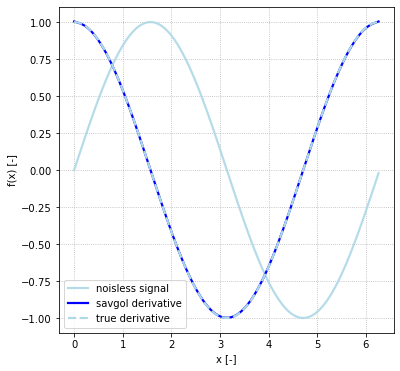

In [9]:
stepsize = x[1]-x[0]
noiseless_derivative = savgol_filter( y, window_length, polyorder=2, deriv=1, delta=stepsize )
actual_derivative = cos( x )

fig, ax = plt.subplots( figsize=(6,6))
ax.plot( x, y, color='lightblue', alpha=0.9, lw=2.2, label='noisless signal')
ax.plot( x, noiseless_derivative, color='blue', lw=2.2, label='savgol derivative')
ax.plot( x, actual_derivative, color='lightblue', ls='--', lw=2.2, label='true derivative')

add_style( ax)

Text(0.5, 1.0, 'direct derivatives')

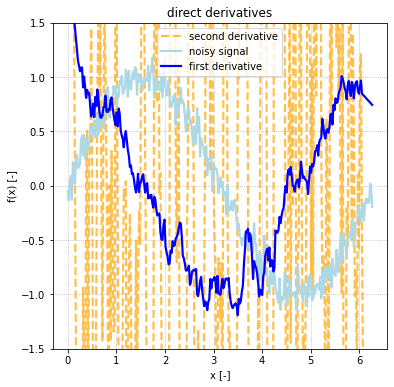

In [10]:
stepsize = x[1]-x[0]
window_length =21
first_derivative = savgol_filter( signal, window_length, polyorder=2, deriv=1, delta=stepsize )
second_derivative = savgol_filter( signal, window_length, polyorder=3, deriv=2, delta=stepsize )

fig, ax = plt.subplots( figsize=(6,6))
ax.plot( x, second_derivative, color='orange', ls='--', alpha=0.7, lw=2.2, label='second derivative')
ax.plot( x, signal, color='lightblue', lw=2.2, label='noisy signal')
ax.plot( x, first_derivative, color='blue', lw=2.2, label='first derivative')

add_style( ax)
ax.set_ylim( ymin=-1.5, ymax=1.5 )
ax.set_title( 'direct derivatives')

- recall that the first derivative of the first derivative is the second derivative<br>
$\quad \blacktriangleright$ take derivative of 'smoothed' derivative

Text(0.5, 1.0, 'chained derivatives')

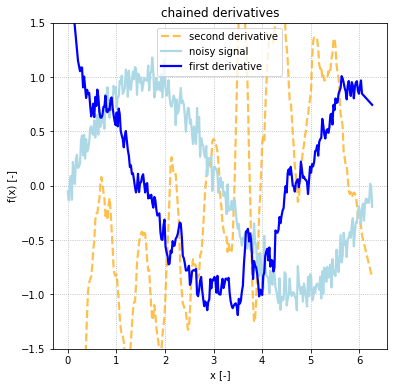

In [11]:
stepsize = x[1]-x[0]
window_length =21
first_derivative = savgol_filter( signal, window_length, polyorder=2, deriv=1, delta=stepsize )
second_derivative = savgol_filter( first_derivative, window_length, polyorder=2, deriv=1, delta=stepsize )

fig, ax = plt.subplots( figsize=(6,6))
ax.plot( x, second_derivative, color='orange', ls='--', alpha=0.7, lw=2.2, label='second derivative')
ax.plot( x, signal, color='lightblue', lw=2.2, label='noisy signal')
ax.plot( x, first_derivative, color='blue', lw=2.2, label='first derivative')

add_style( ax)
ax.set_ylim( ymin=-1.5, ymax=1.5 )
ax.set_title( 'chained derivatives')